<a href="https://colab.research.google.com/github/Ayman-Abdeen/chatboot-/blob/main/BERT/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 123 kB 6.7 MB/s 
     |████████████████████████████████| 90 kB 7.1 MB/s 
     |████████████████████████████████| 132 kB 38.3 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 8.5 MB 31.1 MB/s 
     |████████████████████████████████| 138 kB 39.5 MB/s 
     |████████████████████████████████| 127 kB 36.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
import json
def readJson(filename):
  with open(filename, 'r') as file:
    intents = json.load(file)
    return intents

In [ ]:
medical = readJson('intents.json')

In [ ]:
#medical_DF = pd.DataFrame.from_dict(medical)
#medical_DF

In [ ]:

medical_DF = pd.DataFrame(columns=["label", "sentence"])

In [ ]:
medical_DF

,label,sentence
0,Cuts,What to do if Cuts?
1,Cuts,How to cure Cuts?
2,Cuts,Which medicine to apply for Cuts?
3,Cuts,what to apply on cuts?
4,Cuts,Cuts
...,...,...
183,CPR,How to help a drowning person in CPR?
184,Fracture,How do you treat a Fracture?
185,Fracture,what to do if i get a Fracture?
186,Fracture,Which medicine to take if I have a Fracture?


In [ ]:
all_words = []
tags = []
xy = []
i=0
# loop through each sentence in our intents patterns
for intent in medical['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:

        medical_DF.loc[i] = [tag, pattern]


        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))
        i=i+1
    

In [ ]:
len(xy)

188

In [ ]:
labels_DF = medical_DF.label.values

# create training data
labels = []
for train_label in labels_DF:
    
    label = tags.index(train_label)
    labels.append(label)

y_train = np.array(labels)

In [ ]:
labels_DF

array(['Cuts', 'Cuts', 'Cuts', 'Cuts', 'Cuts', 'Abrasions', 'Abrasions',
       'Abrasions', 'Abrasions', 'Abrasions', 'Abrasions', 'stings',
       'stings', 'stings', 'stings', 'Splinter', 'Splinter', 'Splinter',
       'Splinter', 'Sprains', 'Sprains', 'Sprains', 'Sprains', 'Strains',
       'Strains', 'Strains', 'Strains', 'Strains', 'Strains', 'Fever',
       'Fever', 'Fever', 'Fever', 'Nasal Congestion', 'Nasal Congestion',
       'Nasal Congestion', 'Nasal Congestion', 'Nasal Congestion',
       'Nasal Congestion', 'Cough', 'Cough', 'Cough', 'Cough', 'Cough',
       'Sore Throat', 'Sore Throat', 'Sore Throat', 'Sore Throat',
       'Gastrointestinal problems', 'Gastrointestinal problems',
       'Gastrointestinal problems', 'Gastrointestinal problems',
       'Skin problems', 'Skin problems', 'Skin problems', 'Skin problems',
       'Abdonominal Pain', 'Abdonominal Pain', 'Abdonominal Pain',
       'Abdonominal Pain', 'Bruises', 'Bruises', 'Bruises', 'Bruises',
       'Broken To

In [ ]:
y_train

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,
        3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10,
       10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14,
       15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19,
       19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23,
       23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27,
       27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31,
       32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36,
       36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40,
       40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43,
       43])

In [ ]:
# Create sentence and label lists
sentences = medical_DF.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
#labels = medical_DF.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 941180.45B/s]


Tokenize the first sentence:
['[CLS]', 'what', 'to', 'do', 'if', 'cuts', '?', '[SEP]']


In [ ]:
print('Average word length of sentence is {0:.0f}.'.format(np.mean(medical_DF['sentence'].astype(str).apply(lambda x: len(x.split())))))

Average word length of sentence is 7.


In [ ]:
print('max word length of sentence is {0:.0f}.'.format(np.max(medical_DF['sentence'].astype(str).apply(lambda x: len(x.split())))))

max word length of sentence is 11.


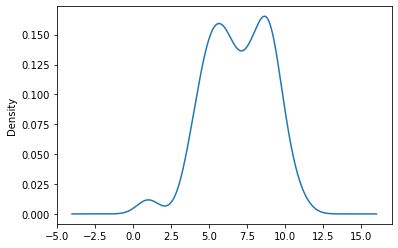

In [ ]:
medical_DF['sentence'].astype(str).apply(lambda x: len(x.split())).plot(kind='kde'); #box , kde

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 11

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
attention_masks

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.

In [ ]:
labels

[0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 26,
 27,
 27,
 27,
 27,
 28,
 28,
 28,
 28,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 34,
 34,
 34,
 34,
 35,
 35,
 35,
 35,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 38,
 38,
 38,
 38,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 41,
 41,
 41,
 41,
 42,
 42,
 42,
 42,
 43,
 43,
 43,
 43]

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_inputs.shape

torch.Size([169, 11])

In [ ]:
train_masks.shape

torch.Size([169, 11])

In [ ]:
train_labels.shape

torch.Size([169])

In [ ]:
input_size_ = len(train_inputs[0])
input_size_

11

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
len(labels_DF)

188

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=44)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
repr(model)

'BertForSequenceClassification(\n  (bert): BertModel(\n    (embeddings): BertEmbeddings(\n      (word_embeddings): Embedding(30522, 768, padding_idx=0)\n      (position_embeddings): Embedding(512, 768)\n      (token_type_embeddings): Embedding(2, 768)\n      (LayerNorm): BertLayerNorm()\n      (dropout): Dropout(p=0.1, inplace=False)\n    )\n    (encoder): BertEncoder(\n      (layer): ModuleList(\n        (0): BertLayer(\n          (attention): BertAttention(\n            (self): BertSelfAttention(\n              (query): Linear(in_features=768, out_features=768, bias=True)\n              (key): Linear(in_features=768, out_features=768, bias=True)\n              (value): Linear(in_features=768, out_features=768, bias=True)\n              (dropout): Dropout(p=0.1, inplace=False)\n            )\n            (output): BertSelfOutput(\n              (dense): Linear(in_features=768, out_features=768, bias=True)\n              (LayerNorm): BertLayerNorm()\n              (dropout): Dropout(p=

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
labels

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 20

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   5%|▌         | 1/20 [00:01<00:36,  1.90s/it]

Train loss: 0.3744067798058192
Validation Accuracy: 0.8421052631578947


Epoch:  10%|█         | 2/20 [00:03<00:32,  1.83s/it]

Train loss: 0.31785782674948376
Validation Accuracy: 0.8421052631578947


Epoch:  15%|█▌        | 3/20 [00:05<00:30,  1.81s/it]

Train loss: 0.2586391381919384
Validation Accuracy: 0.8421052631578947


Epoch:  20%|██        | 4/20 [00:07<00:28,  1.79s/it]

Train loss: 0.24714350700378418
Validation Accuracy: 0.8421052631578947


Epoch:  25%|██▌       | 5/20 [00:08<00:26,  1.78s/it]

Train loss: 0.2193107157945633
Validation Accuracy: 0.8421052631578947


Epoch:  30%|███       | 6/20 [00:10<00:24,  1.78s/it]

Train loss: 0.20417031894127527
Validation Accuracy: 0.8421052631578947


Epoch:  35%|███▌      | 7/20 [00:12<00:23,  1.78s/it]

Train loss: 0.18927597751220068
Validation Accuracy: 0.8421052631578947


Epoch:  40%|████      | 8/20 [00:14<00:21,  1.77s/it]

Train loss: 0.16829944650332132
Validation Accuracy: 0.8421052631578947


Epoch:  45%|████▌     | 9/20 [00:16<00:19,  1.77s/it]

Train loss: 0.1537176842490832
Validation Accuracy: 0.8421052631578947


Epoch:  50%|█████     | 10/20 [00:17<00:17,  1.77s/it]

Train loss: 0.13850374023119608
Validation Accuracy: 0.8421052631578947


Epoch:  55%|█████▌    | 11/20 [00:19<00:15,  1.77s/it]

Train loss: 0.1305979403356711
Validation Accuracy: 0.8421052631578947


Epoch:  60%|██████    | 12/20 [00:21<00:14,  1.77s/it]

Train loss: 0.1302654668688774
Validation Accuracy: 0.8421052631578947


Epoch:  65%|██████▌   | 13/20 [00:23<00:12,  1.77s/it]

Train loss: 0.11073635891079903
Validation Accuracy: 0.8421052631578947


Epoch:  70%|███████   | 14/20 [00:24<00:10,  1.77s/it]

Train loss: 0.10709661742051442
Validation Accuracy: 0.8421052631578947


Epoch:  75%|███████▌  | 15/20 [00:26<00:08,  1.77s/it]

Train loss: 0.10106096292535464
Validation Accuracy: 0.8421052631578947


Epoch:  80%|████████  | 16/20 [00:28<00:07,  1.77s/it]

Train loss: 0.09674600263436635
Validation Accuracy: 0.8421052631578947


Epoch:  85%|████████▌ | 17/20 [00:30<00:05,  1.77s/it]

Train loss: 0.09481411675612132
Validation Accuracy: 0.8421052631578947


Epoch:  90%|█████████ | 18/20 [00:32<00:03,  1.77s/it]

Train loss: 0.08805353194475174
Validation Accuracy: 0.8421052631578947


Epoch:  95%|█████████▌| 19/20 [00:33<00:01,  1.77s/it]

Train loss: 0.08432308584451675
Validation Accuracy: 0.8421052631578947


Epoch: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]

Train loss: 0.07862347364425659
Validation Accuracy: 0.8421052631578947


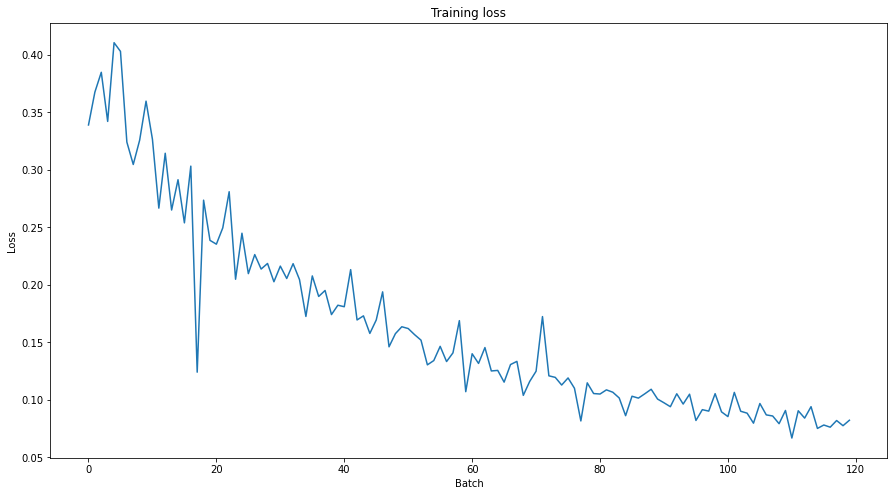

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
#save_model
data = {
"model_state": model.state_dict()
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')

training complete. file saved to data.pth


In [ ]:
FILE = "data.pth"
data = torch.load(FILE)